# Lab-2 Quantum Error Correction

## Part 0: Setup

Please make sure you have the requirment installed correctly by running the following cell

In [53]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeKolkataV2

## Part 1: The Repetition Code [40 Points]

In this first part you will construct the repetition code. The repetition code is one of the most basic quantum error correction codes. Like the classical repetition code, it uses redundancy to protect information from noise.

The basic scheme is that we use 3 entangled data qubits instead of one. Then the detection of errors can be performed through checking if the parities of the qubits agree or no.



### Question 1   [20 Points]

a. Following the notes from the lecture, please construct a circuit 3-qubit repitition code. 


In [54]:
def flip_repetition_code_3_qubits_with_error(phase_flip, qubits_to_flip):
    qc = QuantumCircuit(5, 3)
    qc.cnot(0, 1)
    qc.cnot(0, 2)
    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
    qc.barrier()

    for qubit in qubits_to_flip:
        if qubit is None:
            continue
        if phase_flip:
            qc.z(qubit)
        else:
            qc.x(qubit)
    qc.barrier()

    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
    qc.cnot(0, 3)
    qc.cnot(1, 3)
    qc.cnot(1, 4)
    qc.cnot(2, 4)
    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
    qc.barrier()

    qc.measure([3, 4], [0, 1])
    qc.barrier()

    return qc

def flip_repetition_code_5_qubits_with_error(phase_flip, qubits_to_flip):
    qc = QuantumCircuit(9, 5)
    qc.cnot(0, 1)
    qc.cnot(0, 2)
    qc.cnot(0, 3)
    qc.cnot(0, 4)
    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
        qc.h(3)
        qc.h(4)
    qc.barrier()

    for qubit in qubits_to_flip:
        if qubit is None:
            continue
        if phase_flip:
            qc.z(qubit)
        else:
            qc.x(qubit)
    qc.barrier()

    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
        qc.h(3)
        qc.h(4)
    
    qc.cnot(0, 5)
    qc.cnot(1, 5)
    qc.cnot(1, 6)
    qc.cnot(2, 6)
    qc.cnot(2, 7)
    qc.cnot(3, 7)
    qc.cnot(3, 8)
    qc.cnot(4, 8)
    qc.barrier()

    qc.measure([5, 6, 7, 8], [0, 1, 2, 3])
    qc.barrier()

    return qc

In [55]:
def generate_set(num_qubits, num_errors):
    sett = {frozenset({None})}.union(frozenset({qubit}) for qubit in range(num_qubits))
    if num_errors == 1:
        return sett 
    sett = {frozenset(qubit.union(rest)) for qubit in sett for rest in generate_set(num_qubits, num_errors - 1)}
    return sett

def gen_decoder(phase_flip, circuit, num_qubits):
    flip_decoder = dict()
    for qubits_to_flip in generate_set(num_qubits, (num_qubits - 1) // 2):
        qc = circuit(phase_flip, qubits_to_flip)
        backend = Aer.get_backend('statevector_simulator')
        counts = execute(qc, backend, shots=128).result().get_counts()
        # display(plot_histogram(counts))
        assert len(counts) == 1
        flip_decoder[list(counts.keys())[0]] = qubits_to_flip
    return flip_decoder

b. Use your circuits above to find out what the measured syndrome will be for single bit-flip errors. Then create a dictionary that maps bitstrings corresponding to syndromes to the index qubit where the single bit-flip error occurred. Name your dictionary decoder.


In [56]:
bit_flip_decoder_3 = gen_decoder(False, flip_repetition_code_3_qubits_with_error, 3)
phase_flip_decoder_3 = gen_decoder(True, flip_repetition_code_3_qubits_with_error, 3)
bit_flip_decoder_5 = gen_decoder(False, flip_repetition_code_5_qubits_with_error, 5)
phase_flip_decoder_5 = gen_decoder(True, flip_repetition_code_5_qubits_with_error, 5)
print(bit_flip_decoder_3)
print(phase_flip_decoder_3)
print(bit_flip_decoder_5)
print(phase_flip_decoder_5)

{'000': frozenset({None}), '011': frozenset({1}), '010': frozenset({2}), '001': frozenset({0})}
{'000': frozenset({None}), '011': frozenset({1}), '010': frozenset({2}), '001': frozenset({0})}
{'01011': frozenset({1, 4}), '01010': frozenset({2, 3}), '00011': frozenset({1}), '00100': frozenset({3, 4}), '00001': frozenset({0}), '00110': frozenset({2}), '01101': frozenset({0, 3}), '01000': frozenset({4}), '00111': frozenset({0, 2}), '01001': frozenset({0, 4}), '01110': frozenset({2, 4}), '00000': frozenset({None}), '01111': frozenset({1, 3}), '00010': frozenset({0, 1}), '00101': frozenset({1, 2}), '01100': frozenset({3, None})}
{'01011': frozenset({1, 4}), '01010': frozenset({2, 3}), '00011': frozenset({1}), '00100': frozenset({3, 4}), '00001': frozenset({0}), '00110': frozenset({2}), '01101': frozenset({0, 3}), '01000': frozenset({4}), '00111': frozenset({0, 2}), '01001': frozenset({0, 4}), '01110': frozenset({2, 4}), '00000': frozenset({None}), '01111': frozenset({1, 3}), '00010': frozen

c. To put it all together, write a circuit which will a 3-qubit repetition code entangled state, measure the syndrome, correct the error, and then unentangle to recover the original state. Your circuit will be composed with some single bit-flip error state and simulated to test its correctness.

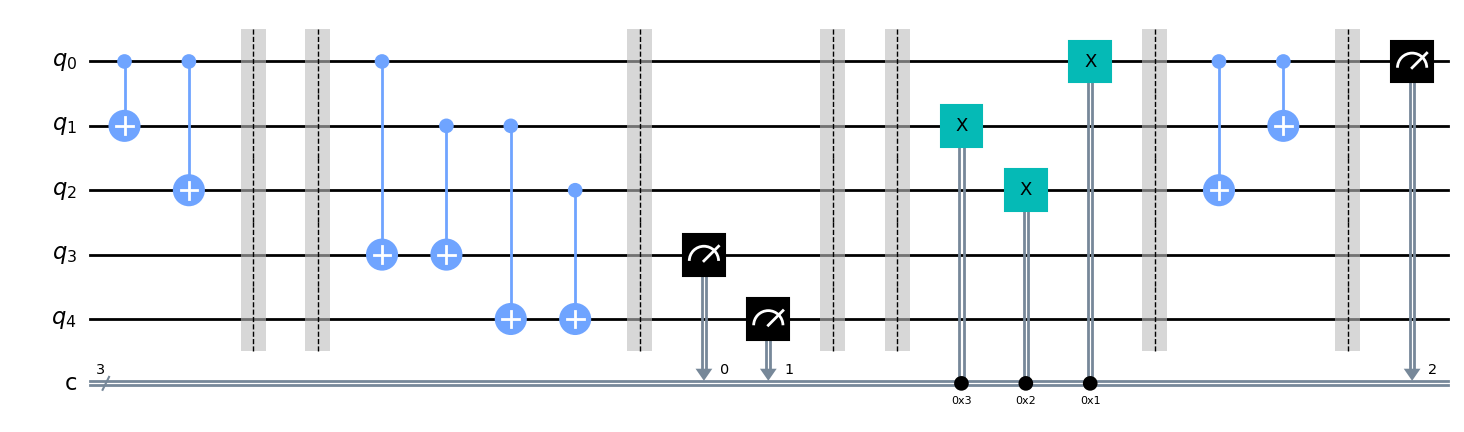

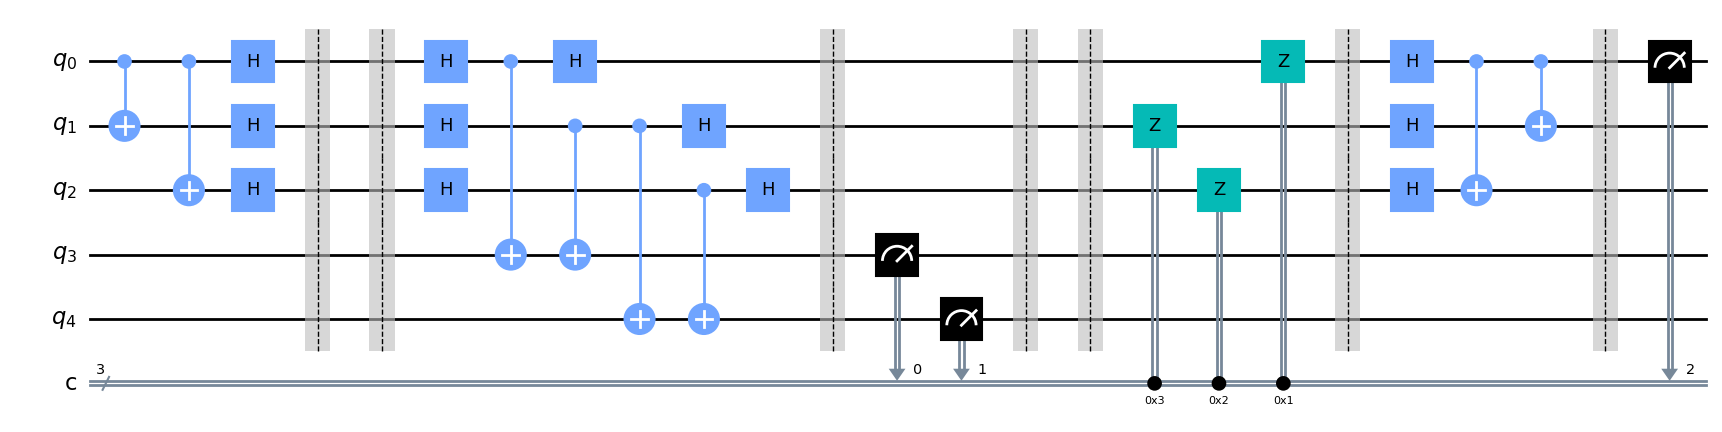

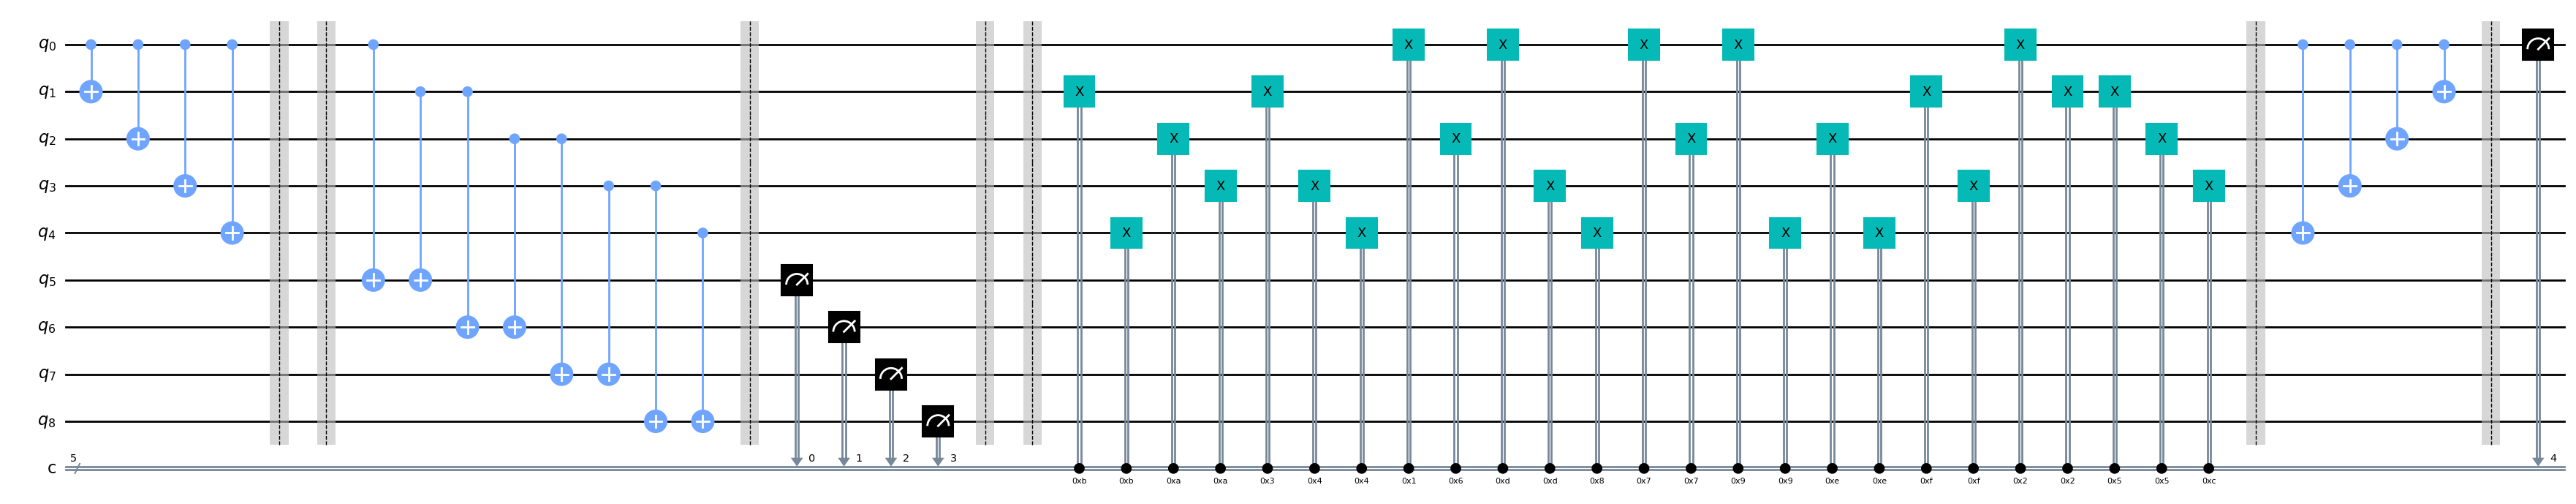

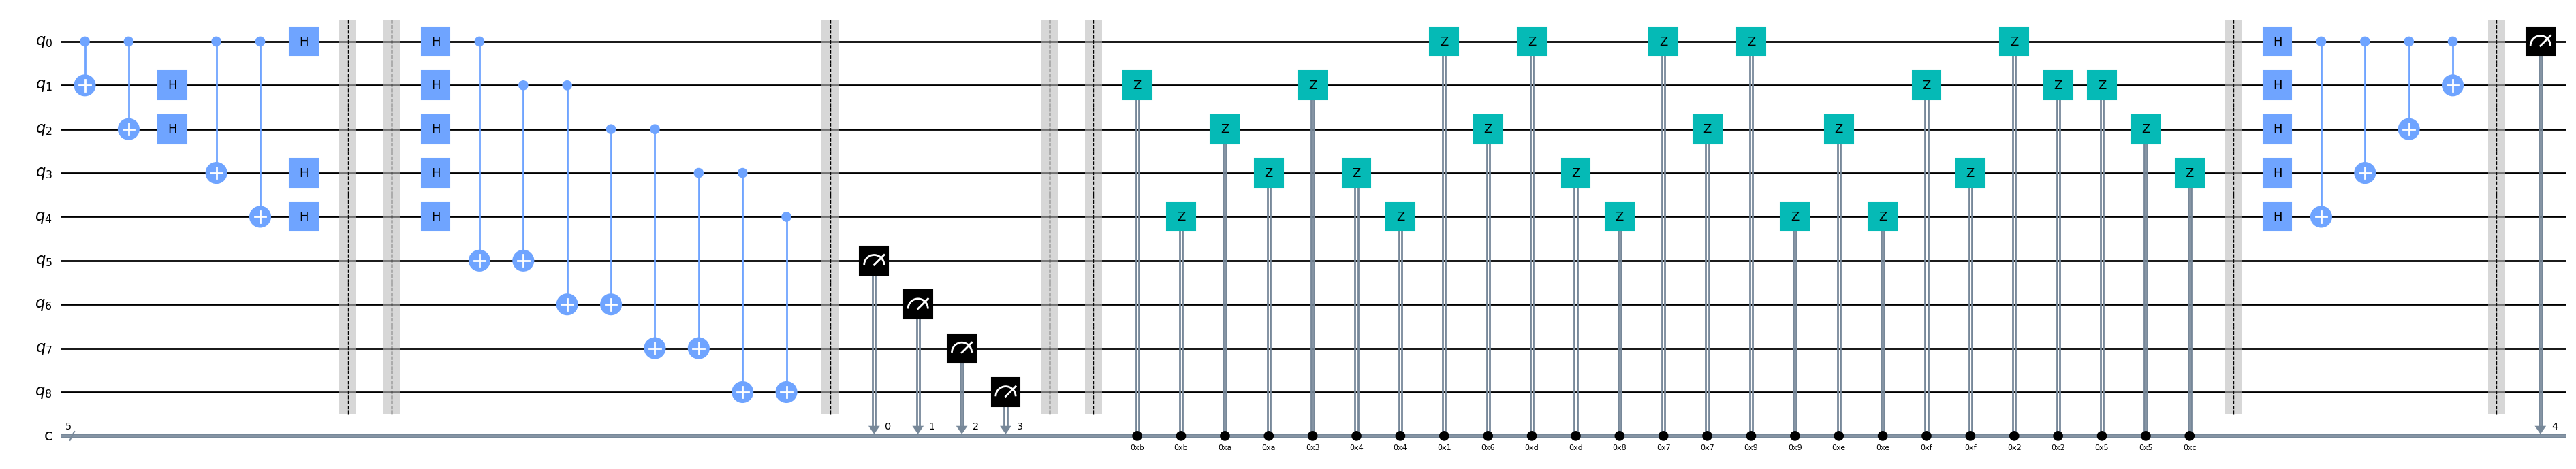

In [57]:
def flip_repetition_code_3_qubits_with_error_correction(phase_flip, qubit_to_flip):
    flip_decoder = phase_flip_decoder_3 if phase_flip else bit_flip_decoder_3
    qc = flip_repetition_code_3_qubits_with_error(phase_flip, qubit_to_flip)
    qc.barrier()
    for (syndrome, qubits_to_flip) in flip_decoder.items():
        for qubit_to_flip in qubits_to_flip:
            if qubit_to_flip != None:
                if phase_flip:
                    qc.z(qubit_to_flip).c_if(qc.cregs[0], int(syndrome, 2))
                else:
                    qc.x(qubit_to_flip).c_if(qc.cregs[0], int(syndrome, 2))

    qc.barrier()
    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
    qc.cnot(0, 2)
    qc.cnot(0, 1)
    qc.barrier()
    qc.measure(0, 2)

    return qc

display(flip_repetition_code_3_qubits_with_error_correction(False, {None}).draw(output='mpl', fold=-1))
display(flip_repetition_code_3_qubits_with_error_correction(True, {None}).draw(output='mpl', fold=-1))

def test_flip_decoder(phase_flip, list_qubits_to_flip, circuit):
    for qubits_to_flip in list_qubits_to_flip:
        qc = circuit(phase_flip, qubits_to_flip)
        backend = Aer.get_backend('statevector_simulator')
        counts = execute(qc, backend).result().get_counts()
        # display(plot_histogram(counts))
        print(qubits_to_flip, list(map(lambda x: x[0], counts.keys())))


def flip_repetition_code_5_qubits_with_error_correction(phase_flip, qubit_to_flip):
    flip_decoder = phase_flip_decoder_5 if phase_flip else bit_flip_decoder_5
    qc = flip_repetition_code_5_qubits_with_error(phase_flip, qubit_to_flip)
    qc.barrier()
    for (syndrome, qubits_to_flip) in flip_decoder.items():
        for qubit_to_flip in qubits_to_flip:
            if qubit_to_flip != None:
                if phase_flip:
                    qc.z(qubit_to_flip).c_if(qc.cregs[0], int(syndrome, 2))
                else:
                    qc.x(qubit_to_flip).c_if(qc.cregs[0], int(syndrome, 2))

    qc.barrier()
    if phase_flip:
        qc.h(0)
        qc.h(1)
        qc.h(2)
        qc.h(3)
        qc.h(4)
    qc.cnot(0, 4)
    qc.cnot(0, 3)
    qc.cnot(0, 2)
    qc.cnot(0, 1)
    qc.barrier()
    qc.measure(0, 4)

    return qc

display(flip_repetition_code_5_qubits_with_error_correction(False, {None}).draw(output='mpl', fold=-1))
display(flip_repetition_code_5_qubits_with_error_correction(True, {None}).draw(output='mpl', fold=-1))

def test_flip_decoder(phase_flip, set_qubits_to_flip, circuit, backend=None):
    plot = True
    for qubits_to_flip in set_qubits_to_flip:
        qc = circuit(phase_flip, qubits_to_flip)
        if backend is None:
            backend = Aer.get_backend('statevector_simulator')
            plot = False
        execution = execute(qc, backend).result()
        counts = execution.get_counts()
        if plot:
            display(plot_histogram(counts))
        print(list(qubits_to_flip), list(counts.keys()), sep=": ")

In [58]:
test_flip_decoder(False, generate_set(3, 1), flip_repetition_code_3_qubits_with_error_correction)
test_flip_decoder(True, generate_set(3, 1), flip_repetition_code_3_qubits_with_error_correction)

[None]: ['000']
[1]: ['011']
[2]: ['010']
[0]: ['001']
[None]: ['000']
[1]: ['011']
[2]: ['010']
[0]: ['001']


### Question 3 [10 Points]

Test if your decoder still works correctly when more than one single bit-flip error is introduced in the 3-qubit repitition code. Following the same steps as in question 1, design a 5-qubit repitition code to correct two bit-flip errors.

### Question 4 [10 Points]

Test if your decoder still works correctly when more than one single phase-flip error is introduced in the 3-qubit repitition code. Following the same steps as in question 1, design a 5-qubit repitition code to correct two phase-flip errors.

In [59]:
test_flip_decoder(False, generate_set(3, 3), flip_repetition_code_3_qubits_with_error_correction)
test_flip_decoder(True, generate_set(3, 3), flip_repetition_code_3_qubits_with_error_correction)

[2]: ['010']
[0, None]: ['001']
[0, 2, None]: ['111']
[2, None]: ['010']
[1, 2]: ['101']
[0, 1, 2]: ['100']
[0, 1]: ['110']
[0, 2]: ['111']
[0, 1, None]: ['110']
[1, None]: ['011']
[1, 2, None]: ['101']
[1]: ['011']
[None]: ['000']
[0]: ['001']
[2]: ['010']
[0, None]: ['001']
[0, 2, None]: ['111']
[2, None]: ['010']
[1, 2]: ['101']
[0, 1, 2]: ['100']
[0, 1]: ['110']
[0, 2]: ['111']
[0, 1, None]: ['110']
[1, None]: ['011']
[1, 2, None]: ['101']
[1]: ['011']
[None]: ['000']
[0]: ['001']


In [60]:
test_flip_decoder(False, generate_set(5, 2), flip_repetition_code_5_qubits_with_error_correction)
print()
test_flip_decoder(True, generate_set(5, 2), flip_repetition_code_5_qubits_with_error_correction)

[1, 4]: ['01011']
[2, 3]: ['01010']
[1, None]: ['00011']
[1]: ['00011']
[3, 4]: ['00100']
[0, None]: ['00001']
[2, None]: ['00110']
[0, 3]: ['01101']
[None, 4]: ['01000']
[0, 2]: ['00111']
[0, 4]: ['01001']
[2, 4]: ['01110']
[None]: ['00000']
[1, 3]: ['01111']
[0, 1]: ['00010']
[4]: ['01000']
[2]: ['00110']
[1, 2]: ['00101']
[3]: ['01100']
[3, None]: ['01100']
[0]: ['00001']

[1, 4]: ['01011']
[2, 3]: ['01010']
[1, None]: ['10011']
[1]: ['10011']
[3, 4]: ['00100']
[0, None]: ['10001']
[2, None]: ['00110']
[0, 3]: ['11101']
[None, 4]: ['01000']
[0, 2]: ['00111']
[0, 4]: ['01001']
[2, 4]: ['11110']
[None]: ['00000']
[1, 3]: ['01111']
[0, 1]: ['10010']
[4]: ['01000']
[2]: ['00110']
[1, 2]: ['00101']
[3]: ['11100']
[3, None]: ['01100']
[0]: ['10001']


### Question 5 [8 Points]

How do measurement errors affect the performance of the decoder? Write a circuit to analyze this question and justify it in your report.

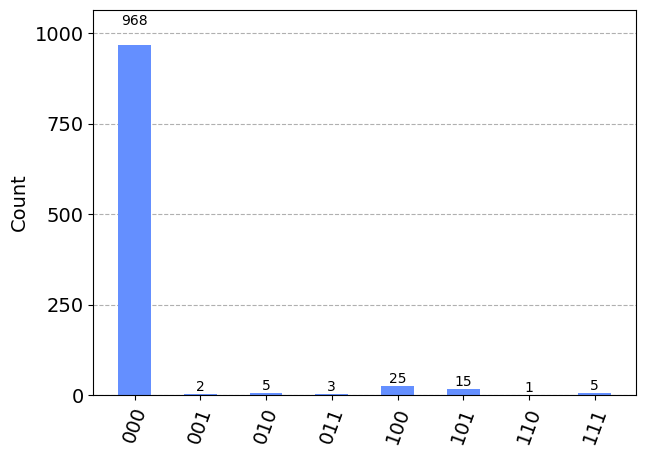

[None]: ['110', '001', '100', '011', '111', '101', '010', '000']


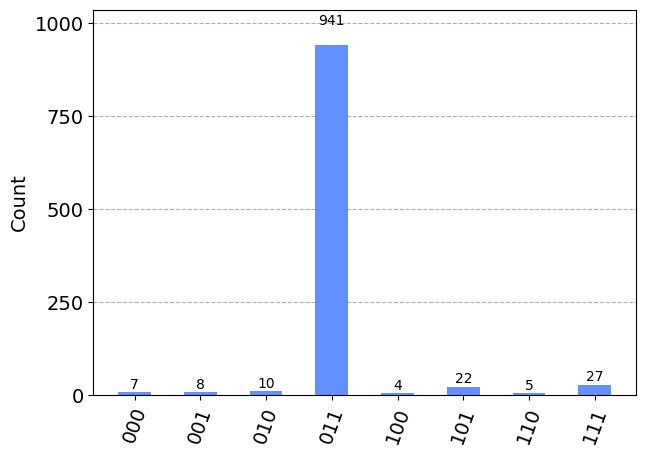

[1]: ['000', '010', '110', '100', '001', '011', '111', '101']


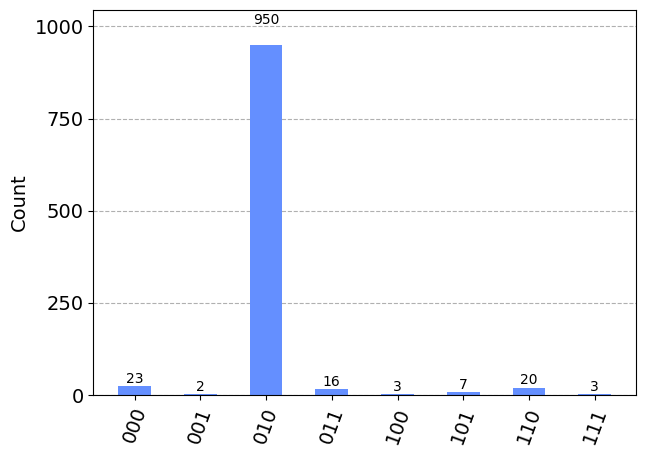

[2]: ['101', '111', '011', '100', '001', '110', '000', '010']


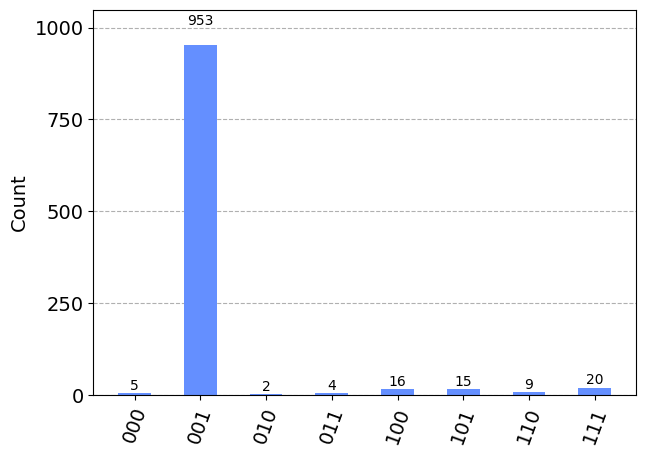

[0]: ['011', '111', '010', '000', '101', '110', '100', '001']


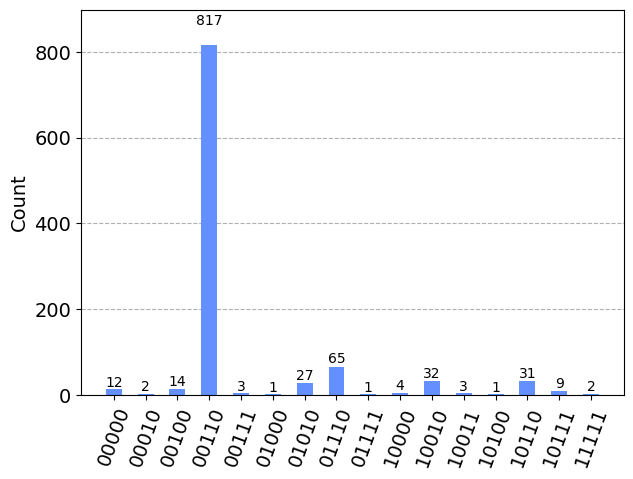

[2]: ['00010', '10100', '10000', '01000', '00110', '10110', '11111', '01111', '10011', '00000', '10111', '01010', '00111', '10010', '01110', '00100']


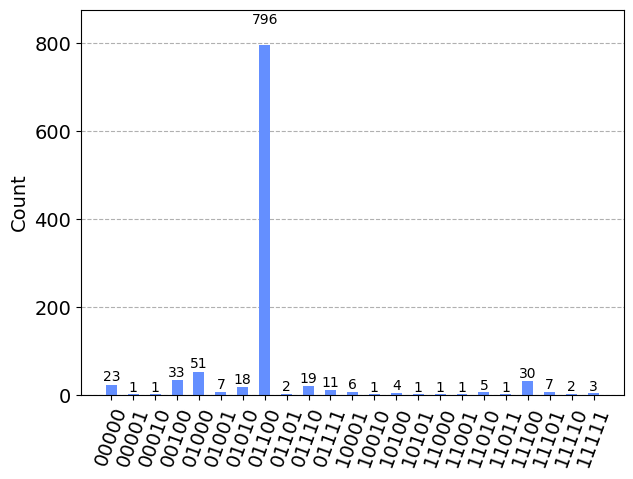

[3]: ['00010', '10101', '10010', '11000', '11110', '11111', '11011', '01001', '01101', '01111', '00001', '11100', '01010', '11001', '11101', '00000', '11010', '01110', '10001', '01000', '00100', '01100', '10100']


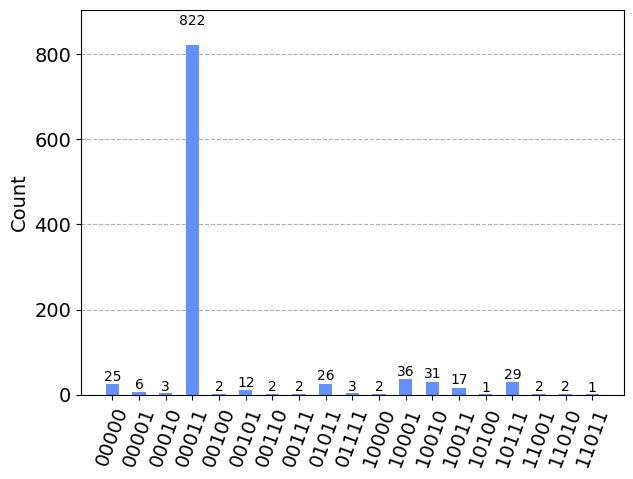

[1]: ['00100', '10100', '00010', '00111', '10000', '11001', '00110', '10010', '11010', '01011', '10111', '10001', '11011', '00101', '01111', '10011', '00000', '00001', '00011']


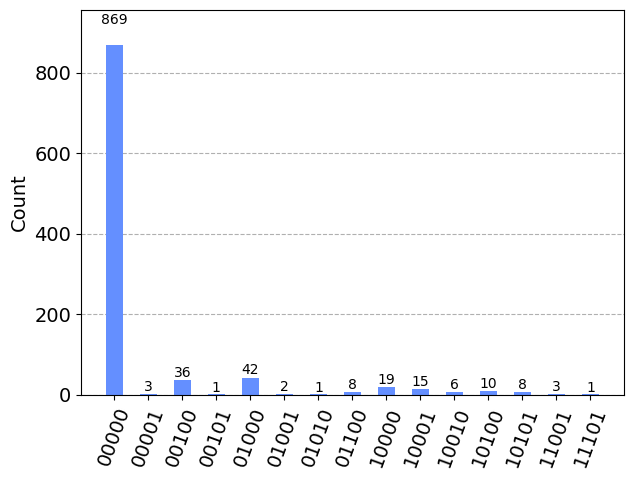

[None]: ['00101', '01010', '00001', '01001', '11101', '10000', '11001', '10010', '10101', '01100', '00100', '10100', '10001', '01000', '00000']


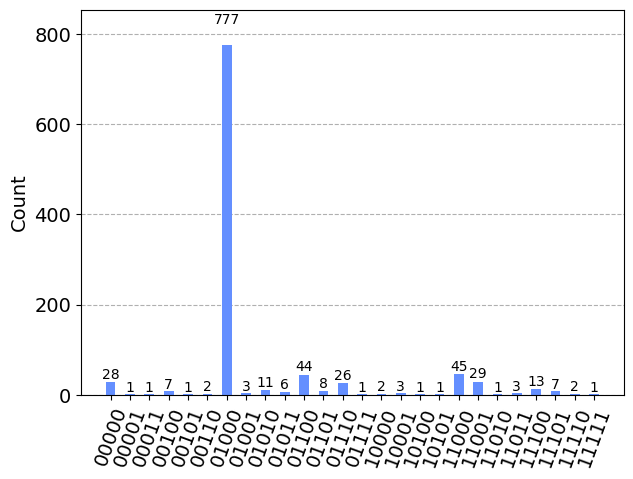

[4]: ['00001', '11010', '00101', '10101', '00011', '11110', '10100', '11111', '11101', '00110', '01011', '01111', '01101', '00000', '01100', '00100', '11011', '01001', '01010', '11100', '10001', '01000', '01110', '10000', '11001', '11000']


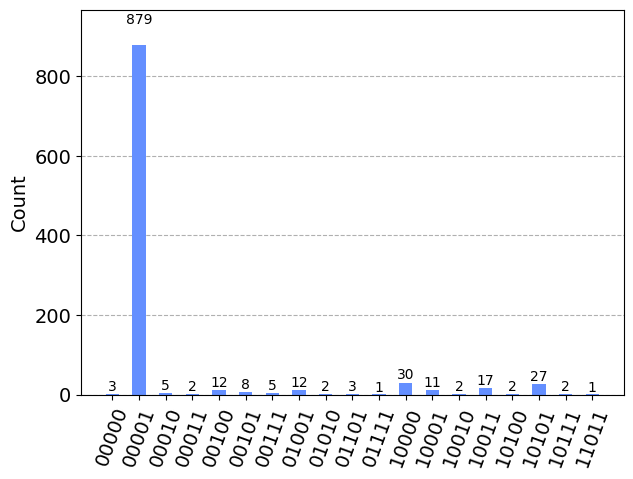

[0]: ['10111', '01010', '00010', '10010', '00000', '00101', '01001', '11011', '10000', '01111', '01101', '10011', '10100', '10001', '10101', '00111', '00001', '00011', '00100']


In [40]:
test_flip_decoder(False, generate_set(3, 1), flip_repetition_code_3_qubits_with_error_correction, AerSimulator.from_backend(FakeKolkataV2()))
test_flip_decoder(False, generate_set(5, 1), flip_repetition_code_5_qubits_with_error_correction, AerSimulator.from_backend(FakeKolkataV2()))

## Part 2: Surface Codes [60 Points]

Repetition codes as we saw can completely correct single bit-flip and phase-flip errors. However, in real systems, both phase-flip and bit-flip errors occur simultaneously. Surface codes are a simple error correcting code that can be used to correct both types of errors at the same time. However, they are limited in the number of errors they can correct. We will implement a distance-3 error correcting code. For the purposes of this lab, we will only consider single errors.


The process will be the same as in the prior part of the lab:
1. Construct the circuit for the code with the ancilla qubits for syndrome extraction.
2. Inject errors into our circuit systematically and determine what the syndromes will be
3. Use that information to construct a simple look up decoder that uses the syndrome to determine the error and correct it
4. Finally construct a complete error detecting and error correcting circuit


Surface codes are the state of the art today, although it is being slowly replaced by alternative codes


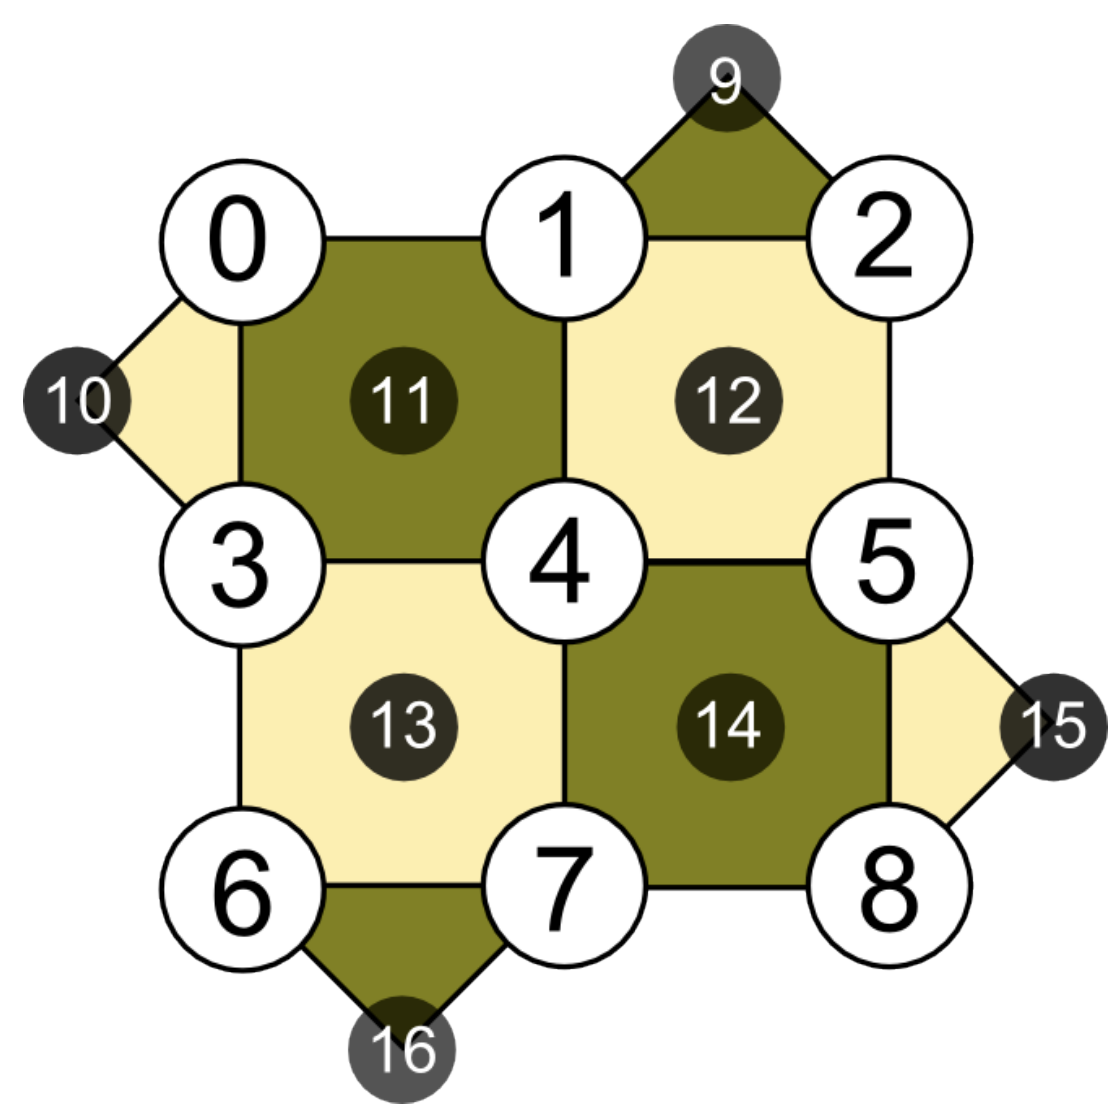

The diagram above can be read as follows. Each of the numbered circles is a qubit. Surface codes, unlike repetition codes, do not have a clear distinction between the parity qubits and the data qubits. What you should think about instead, is the logical qubit, represented by the entirety of the 9 qubits that are white circles. Each of the colored tiles is something known as a stabilizer or check. The checks here can be viewed as the ancilla qubits that we use to make a measurement. As with the repetition code we conduct entanglement measurements on these qubits by entangling them with their neighboring qubits. After entanglement we measure the ancilla qubit as we would normally and the measurements together make up our syndrome. Since the surface codes support both phase-flip and bit-flip errors the entanglements are either CNOT or CZ. Qubits on dark tiles correspond to X checks, i.e. ancilla qubits that are entangled using the CNOT Operation. Qubits on light tiles correspond to Z checks, i.e. ancilla qubits that are entangled using the CZ Operation.




### Question 1 [15 Points]

Construct a circuit to measure the syndrome as indicated in the diagram above.

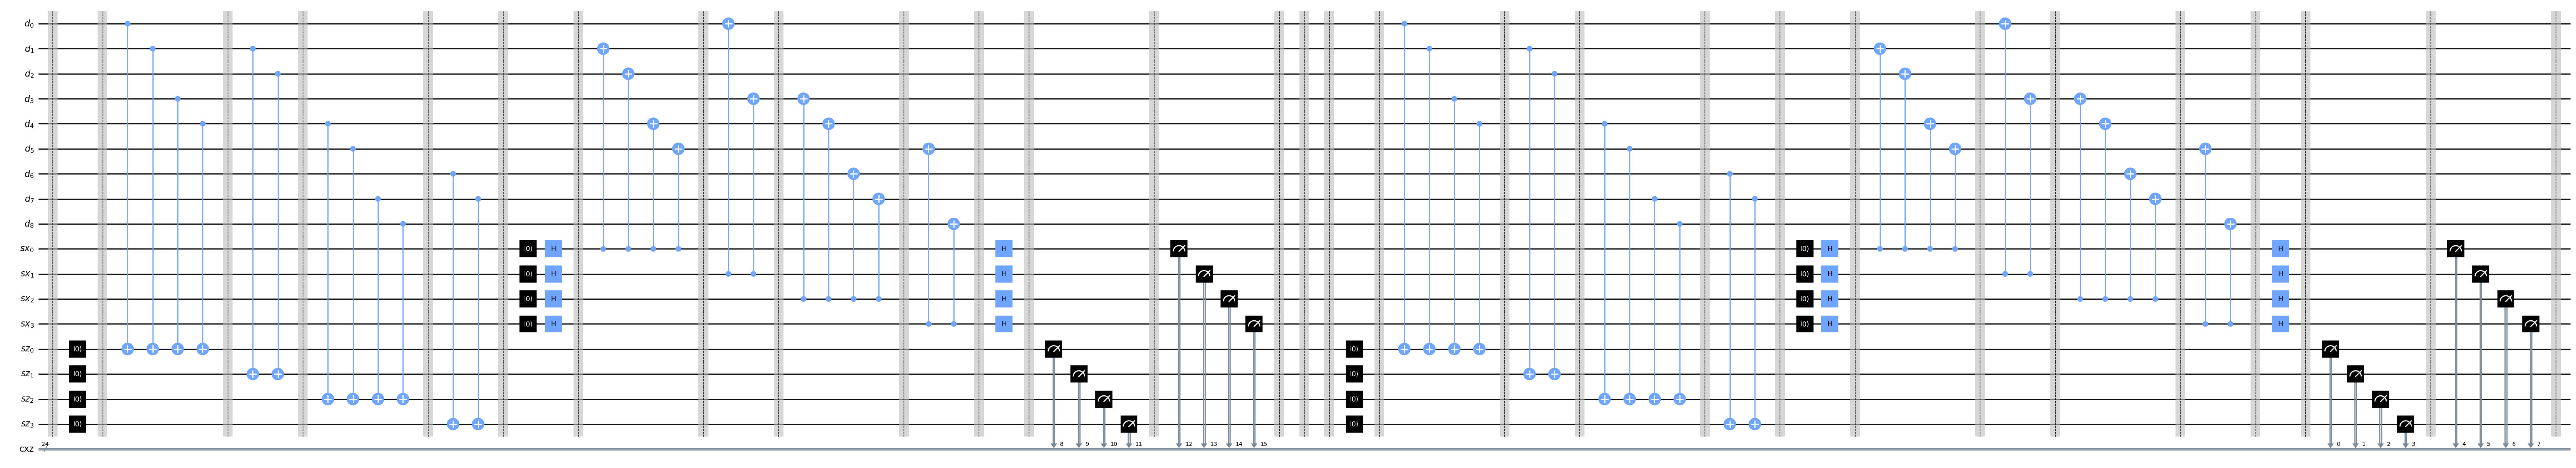

In [28]:
def syndrome_circuit(qc : QuantumCircuit, offset):
    qc.reset(qc.qregs[2])
    qc.barrier()

    # Put data qubits into superposition for Z-syndrome
    qc.cx(qc.qregs[0][0], qc.qregs[2][0])
    qc.cx(qc.qregs[0][1], qc.qregs[2][0])
    qc.cx(qc.qregs[0][3], qc.qregs[2][0])
    qc.cx(qc.qregs[0][4], qc.qregs[2][0])
    qc.barrier()

    qc.cx(qc.qregs[0][1], qc.qregs[2][1])
    qc.cx(qc.qregs[0][2], qc.qregs[2][1])
    qc.barrier()

    qc.cx(qc.qregs[0][4], qc.qregs[2][2])
    qc.cx(qc.qregs[0][5], qc.qregs[2][2])
    qc.cx(qc.qregs[0][7], qc.qregs[2][2])
    qc.cx(qc.qregs[0][8], qc.qregs[2][2])
    qc.barrier()

    qc.cx(qc.qregs[0][6], qc.qregs[2][3])
    qc.cx(qc.qregs[0][7], qc.qregs[2][3])
    qc.barrier()

    qc.reset(qc.qregs[1])
    qc.h(qc.qregs[1])
    qc.barrier()

    # qc.h(qc.qregs[1][0])
    qc.cx(qc.qregs[1][0], qc.qregs[0][1])
    qc.cx(qc.qregs[1][0], qc.qregs[0][2])
    qc.cx(qc.qregs[1][0], qc.qregs[0][4])
    qc.cx(qc.qregs[1][0], qc.qregs[0][5])
    # qc.h(qc.qregs[1][0])
    qc.barrier()

    # qc.h(qc.qregs[1][1])
    qc.cx(qc.qregs[1][1], qc.qregs[0][0])
    qc.cx(qc.qregs[1][1], qc.qregs[0][3])
    # qc.h(qc.qregs[1][1])
    qc.barrier()

    # qc.h(qc.qregs[1][2])
    qc.cx(qc.qregs[1][2], qc.qregs[0][3])
    qc.cx(qc.qregs[1][2], qc.qregs[0][4])
    qc.cx(qc.qregs[1][2], qc.qregs[0][6])
    qc.cx(qc.qregs[1][2], qc.qregs[0][7])
    # qc.h(qc.qregs[1][2])
    qc.barrier()

    # qc.h(qc.qregs[1][3])
    qc.cx(qc.qregs[1][3], qc.qregs[0][5])
    qc.cx(qc.qregs[1][3], qc.qregs[0][8])
    # qc.h(qc.qregs[1][3])
    qc.barrier()

    # for i in range(9):
    #     qc.h(qc.qregs[0][i])
    qc.h(qc.qregs[1])
    qc.barrier()

    # Measure the syndrome qubits
    qc.measure(qc.qregs[2], qc.cregs[0][offset:offset+4])
    qc.barrier()
    qc.measure(qc.qregs[1], qc.cregs[0][offset+4:offset+8])
    qc.barrier()

    return qc

def rotated_surface_code(qubits_to_bit_flip, qubits_to_phase_flip):
    # Initialize registers: 9 data qubits (d), 4 X-syndrome qubits (sz), 4 Z-syndrome qubits (sz)
    d = QuantumRegister(9, 'd')
    sx = QuantumRegister(4, 'sx')
    sz = QuantumRegister(4, 'sz')

    # Classical registers for the syndrome measurements
    cxz = ClassicalRegister(24, 'cxz')

    # Create the quantum circuit
    qc = QuantumCircuit(d, sx, sz, cxz)
    qc.barrier()

    syndrome_circuit(qc, 8)

    # inject errors
    for qubit in qubits_to_bit_flip:
        if qubit is None:
            continue
        qc.x(qubit)
    qc.barrier()

    for qubit in qubits_to_phase_flip:
        if qubit is None:
            continue
        qc.z(qubit)
    qc.barrier()

    syndrome_circuit(qc, 0)

    return qc

rotated_surface_code({}, {}).draw(output='mpl', fold=-1)

### Question 2 [15 Points]

Use the circuit you implmented above to create a decoder single bit-flip errors and another decoder for single phase-flip errors. Note that the errors are independent and can be decoded in parallel. You may put the decoders together if you wish.

In [12]:
def gen_surface_code_decoder():
    decoder = dict()
    for qubits_to_bit_flip in generate_set(9, 1):
        for qubits_to_phase_flip in generate_set(9, 1):
            qc = rotated_surface_code(qubits_to_bit_flip, qubits_to_phase_flip)
            # display(qc.draw(output='mpl', fold=-1))
            backend = Aer.get_backend('statevector_simulator')
            counts = execute(qc, backend).result().get_counts()
            # display(plot_histogram(counts))
            # print(list(counts.keys()), qubits_to_bit_flip, qubits_to_phase_flip)
            # assert len(counts) == 1
            keys = list(counts.keys())[0].split(" ")[0]
            decoder[int(keys[8:16], 2) ^ int(keys[16:24], 2)] = (qubits_to_bit_flip, qubits_to_phase_flip)
    return decoder

surface_code_decoder = gen_surface_code_decoder()
for (syndrome, qubits_to_flip) in sorted(surface_code_decoder.items()):
    print(syndrome, qubits_to_flip)

0 (frozenset({None}), frozenset({None}))
1 (frozenset({0}), frozenset({None}))
2 (frozenset({2}), frozenset({None}))
3 (frozenset({1}), frozenset({None}))
4 (frozenset({5}), frozenset({None}))
5 (frozenset({4}), frozenset({None}))
8 (frozenset({6}), frozenset({None}))
12 (frozenset({7}), frozenset({None}))
16 (frozenset({None}), frozenset({1}))
17 (frozenset({0}), frozenset({1}))
18 (frozenset({2}), frozenset({1}))
19 (frozenset({1}), frozenset({1}))
20 (frozenset({5}), frozenset({1}))
21 (frozenset({4}), frozenset({1}))
24 (frozenset({6}), frozenset({1}))
28 (frozenset({7}), frozenset({1}))
32 (frozenset({None}), frozenset({0}))
33 (frozenset({0}), frozenset({0}))
34 (frozenset({2}), frozenset({0}))
35 (frozenset({1}), frozenset({0}))
36 (frozenset({5}), frozenset({0}))
37 (frozenset({4}), frozenset({0}))
40 (frozenset({6}), frozenset({0}))
44 (frozenset({7}), frozenset({0}))
64 (frozenset({None}), frozenset({6}))
65 (frozenset({0}), frozenset({6}))
66 (frozenset({2}), frozenset({6}))

### Question 3 [15 Points]

Congratulations your now ready to implement an error correction circuit. Using your decoder and your circuit please complete the following function which returns an error correcting circuit that detects and corrects single bit-flip or phase-flip errors. The code will be tested by prepending the circuit with the circuit that inserts a single error at an arbitrary data qubit.

In [34]:
def rotated_surface_code_with_error_correction(qubits_to_bit_flip, qubits_to_phase_flip, measure_error):
    qc = rotated_surface_code(qubits_to_bit_flip, qubits_to_phase_flip)
    qc.barrier()

    for i in range(1 << 8):
        for (syndrome, (qubits_to_bit_flip, qubits_to_phase_flip)) in surface_code_decoder.items():
            if measure_error is not None:
                syndrome = syndrome ^ (1 << measure_error)
            for qubit_to_flip in qubits_to_bit_flip:
                if qubit_to_flip is not None:
                    qc.x(qubit_to_flip).c_if(qc.cregs[0], (i << 8) | (i ^ syndrome))
            for qubit_to_flip in qubits_to_phase_flip:
                if qubit_to_flip is not None:
                    qc.z(qubit_to_flip).c_if(qc.cregs[0], (i << 8) | (i ^ syndrome))

    syndrome_circuit(qc, 16)
    # display(qc.draw(output='mpl', fold=-1))

    return qc

# display(rotated_surface_code_with_error_correction({}, {}).draw(output='mpl', fold=1000))

def test_surface_code_decoder(set_qubits_to_bit_flip, set_qubits_to_phase_flip, measure_error=None):
    for qubits_to_bit_flip in set_qubits_to_bit_flip:
        for qubits_to_phase_flip in set_qubits_to_phase_flip:
            qc = rotated_surface_code_with_error_correction(qubits_to_bit_flip, qubits_to_phase_flip, measure_error)
            backend = Aer.get_backend('statevector_simulator')
            execution = execute(qc, backend).result()
            counts = execution.get_counts()
            # display(plot_histogram(counts))
            keys = list(counts.keys())[0]
            final, first, syndrome = keys[0:8], keys[8:16], keys[16:24]
            print(list(qubits_to_bit_flip), list(qubits_to_phase_flip), first, syndrome, final)

In [38]:
test_surface_code_decoder(generate_set(9, 1), generate_set(9, 1))

[2] [2] 10100000 10110010 10100000
[2] [8] 01100000 11100010 01100000
[2] [7] 10100000 11100010 10100000
[2] [3] 11100000 10000010 11100000
[2] [1] 11110000 11100010 11110000
[2] [6] 10000000 11000010 10000000
[2] [5] 10010000 00000010 10010000
[2] [None] 00010000 00010010 00010000
[2] [4] 01110000 00100010 01110000
[2] [0] 01110000 01010010 01110000
[8] [2] 10010000 10000100 10010000
[8] [8] 10110000 00110100 10110000
[8] [7] 10010000 11010100 10010000
[8] [3] 11010000 10110100 11010000
[8] [1] 11110000 11100100 11110000
[8] [6] 00100000 01100100 00100000
[8] [5] 10000000 00010100 10000000
[8] [None] 00100000 00100100 00100000
[8] [4] 01110000 00100100 01110000
[8] [0] 01010000 01110100 01010000
[7] [2] 01010000 01001100 01010000
[7] [8] 00100000 10101100 00100000
[7] [7] 00000000 01001100 00000000
[7] [3] 00010000 01111100 00010000
[7] [1] 11000000 11011100 11000000
[7] [6] 01000000 00001100 01000000
[7] [5] 00110000 10101100 00110000
[7] [None] 11110000 11111100 11110000
[7] [4] 100

### Question 4 [15 Points]

What about measurement errors? Add measurement errors to your syndrome extraction circuit right before extraction. Analyze how this changes the performance of your decoder and error correction.

In [37]:
for measure_error in [None, 0, 1, 2, 3, 4, 5, 6, 7]:
    print("Measure error on qubit", measure_error)
    test_surface_code_decoder(generate_set(3, 1), generate_set(3, 1), measure_error)
    print()

Measure error on qubit None
[None] [None] 11010000 11010000 11010000
[None] [1] 11100000 11110000 11100000
[None] [2] 00100000 00110000 00100000
[None] [0] 11010000 11110000 11010000
[1] [None] 00010000 00010011 00010000
[1] [1] 11000000 11010011 11000000
[1] [2] 00000000 00010011 00000000
[1] [0] 01010000 01110011 01010000
[2] [None] 10100000 10100010 10100000
[2] [1] 11000000 11010010 11000000
[2] [2] 10100000 10110010 10100000
[2] [0] 01000000 01100010 01000000
[0] [None] 11100000 11100001 11100000
[0] [1] 11110000 11100001 11110000
[0] [2] 11010000 11000001 11010000
[0] [0] 00100000 00000001 00100000

Measure error on qubit 0
[None] [None] 10000000 10000000 10000001
[None] [1] 00000000 00010000 00000001
[None] [2] 00110000 00100000 00110001
[None] [0] 00000000 00100000 00000001
[1] [None] 01010000 01010011 01010001
[1] [1] 01100000 01110011 01100001
[1] [2] 01100000 01110011 01100001
[1] [0] 11000000 11100011 11000001
[2] [None] 00110000 00110010 00110001
[2] [1] 01100000 01110010 